In [ ]:
!pip install box2d

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 27.4 MB/s eta 0:00:00


In [ ]:
# Agent Training Functions

import base64
import random
from itertools import zip_longest

import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import tensorflow as tf

SEED = 0  # Seed for the pseudo-random number generator.
MINIBATCH_SIZE = 64  # Mini-batch size.
TAU = 1e-3  # Soft update parameter.
E_DECAY = 0.995  # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01  # Minimum ε value for the ε-greedy policy.


random.seed(SEED)


def get_experiences(memory_buffer):
    """
    Returns a random sample of experience tuples drawn from the memory buffer.

    Retrieves a random sample of experience tuples from the given memory_buffer and
    returns them as TensorFlow Tensors. The size of the random sample is determined by
    the mini-batch size (MINIBATCH_SIZE).

    Args:
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
        A tuple (states, actions, rewards, next_states, done_vals) where:

            - states are the starting states of the agent.
            - actions are the actions taken by the agent from the starting states.
            - rewards are the rewards received by the agent after taking the actions.
            - next_states are the new states of the agent after taking the actions.
            - done_vals are the boolean values indicating if the episode ended.

        All tuple elements are TensorFlow Tensors whose shape is determined by the
        mini-batch size and the given Gym environment. For the Lunar Lander environment
        the states and next_states will have a shape of [MINIBATCH_SIZE, 8] while the
        actions, rewards, and done_vals will have a shape of [MINIBATCH_SIZE]. All
        TensorFlow Tensors have elements with dtype=tf.float32.
    """

    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)


def check_update_conditions(t, num_steps_upd, memory_buffer):
    """
    Determines if the conditions are met to perform a learning update.

    Checks if the current time step t is a multiple of num_steps_upd and if the
    memory_buffer has enough experience tuples to fill a mini-batch (for example, if the
    mini-batch size is 64, then the memory buffer should have more than 64 experience
    tuples in order to perform a learning update).

    Args:
        t (int):
            The current time step.
        num_steps_upd (int):
            The number of time steps used to determine how often to perform a learning
            update. A learning update is only performed every num_steps_upd time steps.
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
       A boolean that will be True if conditions are met and False otherwise.
    """

    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_new_eps(epsilon):
    """
    Updates the epsilon value for the ε-greedy policy.

    Gradually decreases the value of epsilon towards a minimum value (E_MIN) using the
    given ε-decay rate (E_DECAY).

    Args:
        epsilon (float):
            The current value of epsilon.

    Returns:
       A float with the updated value of epsilon.
    """

    return max(E_MIN, E_DECAY * epsilon)


def get_action(q_values, epsilon=0.0):
    """
    Returns an action using an ε-greedy policy.

    This function will return an action according to the following rules:
        - With probability epsilon, it will return an action chosen at random.
        - With probability (1 - epsilon), it will return the action that yields the
        maximum Q value in q_values.

    Args:
        q_values (tf.Tensor):
            The Q values returned by the Q-Network. For the Lunar Lander environment
            this TensorFlow Tensor should have a shape of [1, 4] and its elements should
            have dtype=tf.float32.
        epsilon (float):
            The current value of epsilon.

    Returns:
       An action (numpy.int64). For the Lunar Lander environment, actions are
       represented by integers in the closed interval [0,3].
    """

    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))


def update_target_network(q_network, target_q_network):
    """
    Updates the weights of the target Q-Network using a soft update.

    The weights of the target_q_network are updated using the soft update rule:

                    w_target = (TAU * w) + (1 - TAU) * w_target

    where w_target are the weights of the target_q_network, TAU is the soft update
    parameter, and w are the weights of the q_network.

    Args:
        q_network (tf.keras.Sequential):
            The Q-Network.
        target_q_network (tf.keras.Sequential):
            The Target Q-Network.
    """

    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)


def plot_history(point_history, **kwargs):
    """
    Plots the total number of points received by the agent after each episode together
    with the moving average (rolling mean).

    Args:
        point_history (list):
            A list containing the total number of points the agent received after each
            episode.
        **kwargs: optional
            window_size (int):
                Size of the window used to calculate the moving average (rolling mean).
                This integer determines the fixed number of data points used for each
                window. The default window size is set to 10% of the total number of
                data points in point_history, i.e. if point_history has 200 data points
                the default window size will be 20.
            lower_limit (int):
                The lower limit of the x-axis in data coordinates. Default value is 0.
            upper_limit (int):
                The upper limit of the x-axis in data coordinates. Default value is
                len(point_history).
            plot_rolling_mean_only (bool):
                If True, only plots the moving average (rolling mean) without the point
                history. Default value is False.
            plot_data_only (bool):
                If True, only plots the point history without the moving average.
                Default value is False.
    """

    lower_limit = 0
    upper_limit = len(point_history)

    window_size = (upper_limit * 10) // 100

    plot_rolling_mean_only = False
    plot_data_only = False

    if kwargs:
        if "window_size" in kwargs:
            window_size = kwargs["window_size"]

        if "lower_limit" in kwargs:
            lower_limit = kwargs["lower_limit"]

        if "upper_limit" in kwargs:
            upper_limit = kwargs["upper_limit"]

        if "plot_rolling_mean_only" in kwargs:
            plot_rolling_mean_only = kwargs["plot_rolling_mean_only"]

        if "plot_data_only" in kwargs:
            plot_data_only = kwargs["plot_data_only"]

    points = point_history[lower_limit:upper_limit]

    # Generate x-axis for plotting.
    episode_num = [x for x in range(lower_limit, upper_limit)]

    # Use Pandas to calculate the rolling mean (moving average).
    rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

    plt.figure(figsize=(10, 7), facecolor="white")

    if plot_data_only:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
    elif plot_rolling_mean_only:
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")
    else:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

    text_color = "black"

    ax = plt.gca()
    ax.set_facecolor("black")
    plt.grid()
    plt.xlabel("Episode", color=text_color, fontsize=30)
    plt.ylabel("Total Points", color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter("{x:,}")
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis="x", colors=text_color)
    ax.tick_params(axis="y", colors=text_color)
    plt.show()


def display_table(current_state, action, next_state, reward, done):
    import numpy as np
    import pandas as pd
    from IPython.display import display

    STATE_VECTOR_COL_NAME = 'State Vector'
    DERIVED_COL_NAME = 'Derived from the State Vector (the closer to zero, the better)'

    # States
    add_derived_info = lambda state: np.hstack([
        state,
        [(state[0]**2 + state[1]**2)**.5],
        [(state[2]**2 + state[3]**2)**.5],
        [np.abs(state[4])]
    ])

    modified_current_state = add_derived_info(current_state)
    modified_next_state = add_derived_info(next_state)

    states = np.vstack([
        modified_current_state,
        modified_next_state,
        modified_next_state - modified_current_state,
    ]).T

    get_state = lambda idx, type=np.float32: dict(zip(
        ['Current State', 'Next State'],
        states[idx].astype(type)
    ))

    # Actions
    action_labels = [
        "Do nothing",
        "Fire right engine",
        "Fire main engine",
        "Fire left engine",
    ]

    display(
        pd.DataFrame({
            ('', '', ''): {'Action': action_labels[action], 'Reward': reward, 'Episode Terminated': done},
            (STATE_VECTOR_COL_NAME, 'Coordinate', 'X (Horizontal)'): get_state(0),
            (STATE_VECTOR_COL_NAME, 'Coordinate', 'Y (Vertical)'): get_state(1),
            (STATE_VECTOR_COL_NAME, 'Velocity', 'X (Horizontal)'): get_state(2),
            (STATE_VECTOR_COL_NAME, 'Velocity', 'Y (Vertical)'): get_state(3),
            (STATE_VECTOR_COL_NAME, 'Tilting', 'Angle'): get_state(4),
            (STATE_VECTOR_COL_NAME, 'Tilting', 'Angular Velocity'): get_state(5),
            (STATE_VECTOR_COL_NAME, 'Ground contact', 'Left Leg?'): get_state(6, bool),  # Updated here
            (STATE_VECTOR_COL_NAME, 'Ground contact', 'Right Leg?'): get_state(7, bool),  # Updated here
            (DERIVED_COL_NAME, 'Distance from landing pad', ''): get_state(8),
            (DERIVED_COL_NAME, 'Velocity', ''): get_state(9),
            (DERIVED_COL_NAME, 'Tilting Angle (absolute value)', ''): get_state(10),
        })\
            .fillna('')\
            .reindex(['Current State', 'Action', 'Next State', 'Reward', 'Episode Terminated'])\
            .style\
            .applymap(lambda x: 'background-color : grey' if x == '' else '')\
            .set_table_styles(
                [
                    {"selector": "th", "props": [("border", "1px solid grey"), ('text-align', 'center')]},
                    {"selector": "tbody td", "props": [("border", "1px solid grey"), ('text-align', 'center')]},
                ]
            )
    )


def embed_mp4(filename):
    """
    Embeds an MP4 video file in a Jupyter notebook.

    Args:
        filename (string):
            The path to the the MP4 video file that will be embedded (i.e.
            "./videos/lunar_lander.mp4").

    Returns:
        Returns a display object from the given video file. This will result in the
        video being displayed in the Jupyter Notebook.
    """

    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)

# 1 - Import Packages

We make use of the following packages:

- **numpy**: A package for scientific computing in Python.
- **deque**: Will be our data structure for our memory buffer.
- **namedtuple**: Will be used to store the experience tuples.
- **gym**: A toolkit for developing and testing reinforcement learning algorithms. We are using gym version 0.25.2 in this notebook.
- **PIL.Image**: Needed to render the Lunar Lander environment.
- **tensorflow.keras**: We will use several modules from this framework for building deep learning models.
- **utils**: A module that contains helper functions for this assignment. You do not need to modify the code in this file.

In [ ]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set the random seed for TensorFlow
tf.random.set_seed(SEED)

# 2 - Hyperparameters

In [ ]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

# 3 - The Lunar Lander Environment

In [ ]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

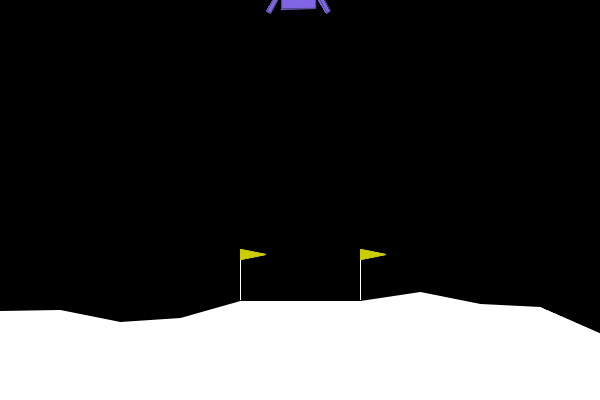

In [ ]:
env.reset()
PIL.Image.fromarray(env.render()[0])

In [ ]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


# 4 - Interacting with the Gym Environment


In [ ]:
# Reset the environment and get the initial state.
current_state = env.reset()

In [ ]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _ = env.step(action)

# Display table with values.
display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

<ipython-input-33-be274af4279d>:318: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color : grey' if x == '' else '')\


# 5 - Deep Q-Learning

In [ ]:
# Create the Q-Network
q_network = Sequential([
    Input(state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
    ])

optimizer = Adam(ALPHA)

In [ ]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

# 6 - Deep Q-Learning Algorithm with Experience Replay


In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    loss = MSE(y_targets, q_values)

    return loss

# 7 - Update the Network Weights

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

# 8 - Train the Agent

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -146.45
Episode 200 | Total point average of the last 100 episodes: -88.58
Episode 300 | Total point average of the last 100 episodes: -64.85
Episode 400 | Total point average of the last 100 episodes: -39.83
Episode 500 | Total point average of the last 100 episodes: 63.65
Episode 600 | Total point average of the last 100 episodes: 195.30
Episode 602 | Total point average of the last 100 episodes: 197.29

Episode 603 | Total point average of the last 100 episodes: 200.02

Environment solved in 603 episodes!

Total Runtime: 2506.32 s (41.77 min)


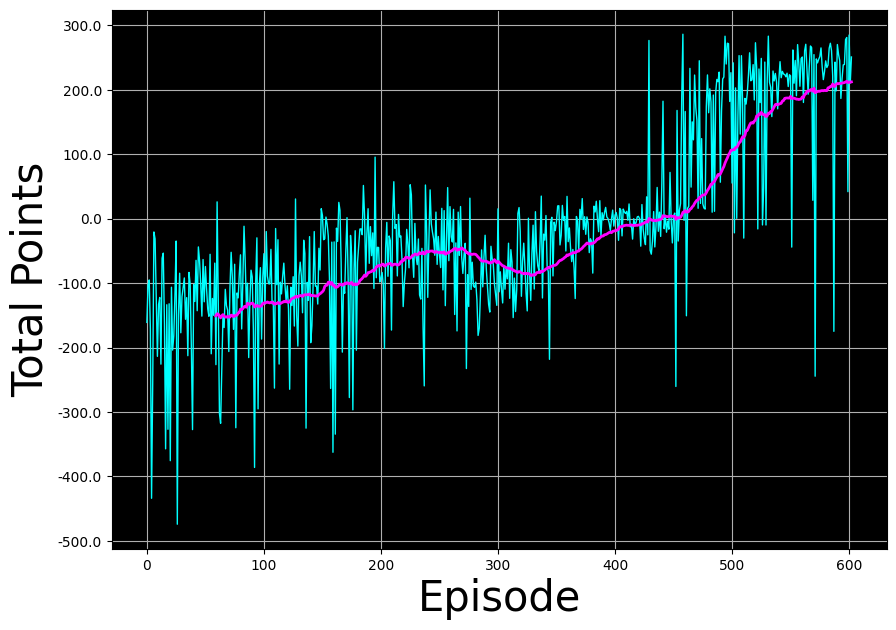

In [ ]:
# Plot the total point history along with the moving average
plot_history(total_point_history)

# 9 - See the Trained Agent In Action

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def create_video(filename, env, q_network, video_callable=None):
    """
    Creates a video of an agent interacting with a Gym environment using Gym's video recording feature.

    Args:
        filename (string):
            The path to the file to which the video will be saved.
        env (Gym Environment):
            The Gym environment the agent will interact with.
        q_network (tf.keras.Sequential):
            A TensorFlow Keras Sequential model that maps states to Q values.
        video_callable (callable, optional):
            A function that takes the current episode number and returns a boolean
            indicating whether to record a video for that episode. If None, videos will
            be recorded for all episodes.

    """
    video = VideoRecorder(env, filename)
    done = False
    state = env.reset()

    while not done:
        q_values = q_network.predict(np.expand_dims(state, axis=0))
        action = np.argmax(q_values[0])
        video.capture_frame()
        state, _, done, _ = env.step(action)

    video.close()
    env.close()

In [ ]:
# Load the model
from tensorflow.keras.models import load_model

q_network = load_model('lunar_lander_model.h5')

# Setup the environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Create and embed video
filename = "trained_agent.mp4"
create_video(filename, env, q_network)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
embed_mp4(filename)